# Import Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize


from sklearn.decomposition import PCA

In [2]:
import seaborn as sns
sns.set()

In [3]:
def create_confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None, display_labels=None,
                           include_values=True, xticks_rotation='horizontal', values_format=None,
                           cmap='viridis', ax=None, colorbar=True):
    
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [4]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [5]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1

    return TP/(TP+FP)

In [6]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [7]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [8]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = []

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0   
    
    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

In [9]:
#df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/binary/wnt_rest.xlsx")
df = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/mb_t1_t2_3way.xlsx")

# NN1 -> NN2

In [10]:
df.head()

,molecular,molec_id,sex,dx_date,age,alive,os,pfs,seg_id,t1_log-sigma-1-mm-3D_firstorder_10Percentile,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,shh,BO_PF-MB_F_0007,F,2000-05-05 00:00:00,79.0,NaN,33,NaN,BO_PF-MB_F_0007_,-14.446979,...,1.973686,0.000808,1027.170040,0.297042,0.562429,1220.949377,0.000601,7.518529,0.134000,5335.217376
1,wnt,BO_PF-MB_F_0008,F,2006-01-05 00:00:00,90.0,Alive,30,NaN,BO_PF-MB_F_0008_,-11.965873,...,0.243711,0.005756,344.000989,0.340258,0.604408,481.129194,0.004316,7.318544,0.252624,209.948818
2,wnt,BO_PF-MB_F_0010,F,2000-08-16 00:00:00,76.0,Alive,92,NaN,BO_PF-MB_F_0010_,-15.311574,...,0.049205,0.000786,4051.276393,0.385322,0.644380,1826.940136,0.000552,8.163314,0.350257,66.167310
3,group3,BO_PF-MB_F_0015,F,2001-01-25 00:00:00,121.0,Alive,84,NaN,BO_PF-MB_F_0015_,-6.059545,...,3.112323,0.003300,481.319732,0.321953,0.586631,463.640209,0.002341,7.438314,0.129236,2106.125227
4,shh,BO_PF-MB_F_0017,F,2004-06-06 00:00:00,27.0,Alive,44,NaN,BO_PF-MB_F_0017_,-25.161749,...,0.094180,0.001028,1305.932045,0.382523,0.642779,1897.521463,0.000611,7.748172,0.291049,174.711614


In [11]:
first_target = df["molecular"]

In [12]:
first_target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [13]:
reduced_features = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/reduced_molec_jigsaw.xlsx")

In [14]:
reduced_features.head()

,wnt_rest,shh_rest,wnt_shh,wnt_group3,3way,group3_rest
0,sex,sex,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,sex,sex,sex
1,age,t1_log-sigma-1-mm-3D_firstorder_Median,t1_wavelet-LHL_glcm_Correlation,age,t1_log-sigma-3-mm-3D_firstorder_Median,age
2,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-5-mm-3D_glszm_GrayLevelVariance,t1_wavelet-LHL_glcm_Idn,t1_original_shape_Flatness,t1_original_glrlm_LowGrayLevelRunEmphasis,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLev...
3,t1_log-sigma-3-mm-3D_firstorder_90Percentile,t1_original_glszm_LargeAreaHighGrayLevelEmphasis,t2_wavelet-HHL_firstorder_InterquartileRange,t1_wavelet-HLH_firstorder_Skewness,t1_original_shape_Flatness,t1_log-sigma-3-mm-3D_firstorder_Median
4,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,t1_original_shape_Flatness,t2_wavelet-LLL_firstorder_Kurtosis,t1_wavelet-LHL_glcm_Correlation,t1_wavelet-HLL_glcm_Correlation,t1_log-sigma-3-mm-3D_glcm_ClusterProminence


In [15]:
reduced_features_list = reduced_features.loc[reduced_features['wnt_rest'].isnull() == False, ['wnt_rest']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [16]:
first_target

0         shh
1         wnt
2         wnt
3      group3
4         shh
        ...  
258       wnt
259    group3
260       shh
261    group3
262    group3
Name: molecular, Length: 263, dtype: object

In [17]:
first_target = first_target.map(dict(wnt = 0, shh = 1, group3 = 1))

In [18]:
first_features = df[reduced_features_list]

In [19]:
sex_binarized = first_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

first_features['sex'] = sex_binarized

<ipython-input-19-7abfed4242db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_features['sex'] = sex_binarized


In [20]:
first_features.head()

,sex,age,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-3-mm-3D_firstorder_90Percentile,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniformityNormalized,t1_wavelet-HLH_firstorder_Skewness,t1_wavelet-LHL_glcm_Correlation,t1_wavelet-LHL_glcm_Idn,t2_wavelet-HHL_glszm_GrayLevelVariance,t2_log-sigma-5-mm-3D_firstorder_90Percentile,t2_wavelet-HHL_firstorder_Median,t1_original_shape_Elongation,t2_wavelet-HHH_firstorder_Median,t2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis
0,0,79.0,0.505918,2.832797,0.151307,0.027467,0.164886,0.939672,4.770017,-3.319491,-0.068953,0.761996,0.000789,381.588056
1,0,90.0,0.432892,0.042016,0.375000,0.127864,0.080252,0.944466,7.629940,-2.592589,0.185444,0.709753,-0.002129,188.395559
2,0,76.0,0.507732,10.378689,0.143779,0.068410,0.013351,0.923938,7.154313,-8.626585,-0.188890,0.846346,0.001038,210.395917
3,0,121.0,0.469566,10.054315,0.314129,-0.137343,0.165649,0.928156,2.720110,-13.716932,0.009982,0.948860,0.001468,100.589683
4,0,27.0,0.577000,1.730672,0.099021,0.036008,0.198333,0.956076,11.583691,4.093615,0.465001,0.705269,-0.000842,312.123409


In [21]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_features, first_target, 
                                                   test_size = 0.25, random_state = 42)

In [22]:
y_train_1.value_counts()

1    181
0     16
Name: molecular, dtype: int64

In [23]:
y_test_1.value_counts()

1    56
0    10
Name: molecular, dtype: int64

In [24]:
first_X = pd.concat([X_train_1, y_train_1], axis = 1)
first_X_0 = first_X[first_X['molecular'] == 0]
first_X_1 = first_X[first_X['molecular'] == 1]

In [25]:
upsampled_0 = resample(first_X_0, replace = True, n_samples = len(first_X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, first_X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [26]:
X_train_1 = upsampled.iloc[:, :-1]
y_train_1 = upsampled.iloc[:, -1]

In [27]:
y_train_1.value_counts()

1    181
0    181
Name: molecular, dtype: int64

In [28]:
names = X_train_1.columns
first_scaler = preprocessing.StandardScaler()

# NN1: wnt1 vs rest1

In [29]:
X_train_1 = first_scaler.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(X_train_1, columns = names)

X_test_1 = first_scaler.transform(X_test_1)
X_test_1 = pd.DataFrame(X_test_1, columns = names)

In [30]:
nn_model_1_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_seq_1_grid = GridSearchCV(estimator=nn_model_1_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [31]:
nn_seq_1_grid.fit(X_train_1, y_train_1)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [32]:
print(nn_seq_1_grid.best_params_)

{'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'constant'}


In [33]:
nn_seq_1_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_seq_1_model.fit(X_train_1, y_train_1)
y_pred_1 = nn_seq_1_model.predict(X_test_1)

In [34]:
np.array(y_test_1)

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [35]:
print("Accuracy Score: " + str(accuracy_score(y_test_1, y_pred_1)))
print("Specificity Score: " + str(specificity_score(y_test_1.to_numpy(), y_pred_1)))
print("Precision: " + str(precision_score(y_test_1, y_pred_1)))
print("Recall: " + str(recall_score(y_test_1, y_pred_1)))
print("F1 Score: " + str(f1_score(y_test_1, y_pred_1)))

#print("PPV Score: " + str(positive_pv_score(y_test_1.to_numpy(), y_pred_1)))
#print("NPV Score: " + str(negative_pv_score(y_test_1.to_numpy(), y_pred_1)))

Accuracy Score: 0.9242424242424242
Specificity Score: 0.6
Precision: 0.9322033898305084
Recall: 0.9821428571428571
F1 Score: 0.9565217391304348


# NN2 - [shh1 vs rest2] decomposed from rest1 

In [36]:
second_target = df["molecular"]

In [37]:
second_target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [38]:
second_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)

In [39]:
second_target = second_target.map(dict(shh = 0, wnt = 1, group3 = 1))
second_target = second_target[second_target != -1]
second_features = second_features.iloc[second_target.index]

In [40]:
second_target.value_counts()

1    180
0     83
Name: molecular, dtype: int64

In [41]:
second_target = second_target.reset_index(drop = True)
second_features = second_features.reset_index(drop = True)

In [42]:
reduced_features.head()

,wnt_rest,shh_rest,wnt_shh,wnt_group3,3way,group3_rest
0,sex,sex,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,sex,sex,sex
1,age,t1_log-sigma-1-mm-3D_firstorder_Median,t1_wavelet-LHL_glcm_Correlation,age,t1_log-sigma-3-mm-3D_firstorder_Median,age
2,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-5-mm-3D_glszm_GrayLevelVariance,t1_wavelet-LHL_glcm_Idn,t1_original_shape_Flatness,t1_original_glrlm_LowGrayLevelRunEmphasis,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLev...
3,t1_log-sigma-3-mm-3D_firstorder_90Percentile,t1_original_glszm_LargeAreaHighGrayLevelEmphasis,t2_wavelet-HHL_firstorder_InterquartileRange,t1_wavelet-HLH_firstorder_Skewness,t1_original_shape_Flatness,t1_log-sigma-3-mm-3D_firstorder_Median
4,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,t1_original_shape_Flatness,t2_wavelet-LLL_firstorder_Kurtosis,t1_wavelet-LHL_glcm_Correlation,t1_wavelet-HLL_glcm_Correlation,t1_log-sigma-3-mm-3D_glcm_ClusterProminence


In [43]:
second_reduced_features_list = reduced_features.loc[reduced_features['shh_rest'].isnull() == False, ['shh_rest']].values.tolist()
second_reduced_features_list = [item for sublist in second_reduced_features_list for item in sublist]

In [44]:
second_features = second_features[second_reduced_features_list]

In [45]:
sex_binarized = second_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

second_features['sex'] = sex_binarized

In [46]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_features, second_target, 
                                                    test_size = 0.25, random_state = 42)

In [47]:
y_train_2.value_counts()

1    128
0     69
Name: molecular, dtype: int64

In [48]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['molecular'] == 0]
second_X_1 = second_X[second_X['molecular'] == 1]

In [49]:
second_upsampled_0 = resample(second_X_0, replace = True, n_samples = len(second_X_1), random_state = 42)
second_upsampled = pd.concat([second_upsampled_0, second_X_1])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [50]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]

In [51]:
y_train_2.value_counts()

1    128
0    128
Name: molecular, dtype: int64

In [52]:
second_names = X_train_2.columns
second_scaler = preprocessing.StandardScaler()

In [53]:
X_train_2 = second_scaler.fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns = second_names)

In [54]:
X_test_2 = second_scaler.transform(X_test_2)
X_test_2 = pd.DataFrame(X_test_2, columns = second_names)

In [55]:
nn_model_2_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_seq_2_grid = GridSearchCV(estimator=nn_model_2_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [56]:
nn_seq_2_grid.fit(X_train_2, y_train_2)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [57]:
print(nn_seq_2_grid.best_params_)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


In [58]:
nn_seq_2_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = nn_seq_2_model.predict(X_test_2)

In [59]:
accuracy_score(y_test_2, y_pred_2)

0.8484848484848485

In [60]:
print("Accuracy Score: " + str(accuracy_score(y_test_2, y_pred_2)))
print("Specificity Score: " + str(specificity_score(y_test_2.to_numpy(), y_pred_2)))
print("Precision: " + str(precision_score(y_test_2, y_pred_2)))
print("Recall: " + str(recall_score(y_test_2, y_pred_2)))
print("F1 Score: " + str(f1_score(y_test_2, y_pred_2)))

print("PPV Score: " + str(positive_pv_score(y_test_2.to_numpy(), y_pred_2)))
print("NPV Score: " + str(negative_pv_score(y_test_2.to_numpy(), y_pred_2)))

Accuracy Score: 0.8484848484848485
Specificity Score: 0.7857142857142857
Precision: 0.9375
Recall: 0.8653846153846154
F1 Score: 0.9
PPV Score: 0.9375
NPV Score: 0.6111111111111112


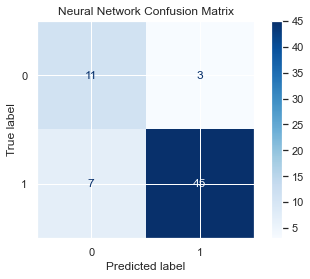

In [61]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

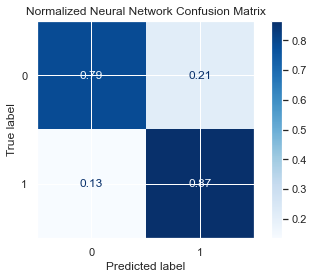

In [62]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# NN3 - [wnt2 vs shh2] decomposed from shh1

In [63]:
third_target = df["molecular"]

In [64]:
third_target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [65]:
third_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)

In [66]:
third_target = third_target.map(dict(wnt = 0, shh = 1, group3 = -1))
third_target = third_target[third_target != -1]
third_features = third_features.iloc[third_target.index]

In [67]:
third_target.value_counts()

1    83
0    26
Name: molecular, dtype: int64

In [68]:
third_target = third_target.reset_index(drop = True)
third_features = third_features.reset_index(drop = True)

In [69]:
reduced_features.head()

,wnt_rest,shh_rest,wnt_shh,wnt_group3,3way,group3_rest
0,sex,sex,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,sex,sex,sex
1,age,t1_log-sigma-1-mm-3D_firstorder_Median,t1_wavelet-LHL_glcm_Correlation,age,t1_log-sigma-3-mm-3D_firstorder_Median,age
2,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-5-mm-3D_glszm_GrayLevelVariance,t1_wavelet-LHL_glcm_Idn,t1_original_shape_Flatness,t1_original_glrlm_LowGrayLevelRunEmphasis,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLev...
3,t1_log-sigma-3-mm-3D_firstorder_90Percentile,t1_original_glszm_LargeAreaHighGrayLevelEmphasis,t2_wavelet-HHL_firstorder_InterquartileRange,t1_wavelet-HLH_firstorder_Skewness,t1_original_shape_Flatness,t1_log-sigma-3-mm-3D_firstorder_Median
4,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,t1_original_shape_Flatness,t2_wavelet-LLL_firstorder_Kurtosis,t1_wavelet-LHL_glcm_Correlation,t1_wavelet-HLL_glcm_Correlation,t1_log-sigma-3-mm-3D_glcm_ClusterProminence


In [70]:
third_reduced_features_list = reduced_features.loc[reduced_features['wnt_shh'].isnull() == False, ['wnt_shh']].values.tolist()
third_reduced_features_list = [item for sublist in third_reduced_features_list for item in sublist]

In [71]:
third_features = third_features[third_reduced_features_list]

In [72]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(third_features, third_target, 
                                                    test_size = 0.25, random_state = 42)

In [73]:
y_train_3.value_counts()

1    60
0    21
Name: molecular, dtype: int64

In [74]:
third_X = pd.concat([X_train_3, y_train_3], axis = 1)
third_X_0 = third_X[third_X['molecular'] == 0]
third_X_1 = third_X[third_X['molecular'] == 1]

In [75]:
third_upsampled_0 = resample(third_X_0, replace = True, n_samples = len(third_X_1), random_state = 42)
third_upsampled = pd.concat([third_upsampled_0, third_X_1])
third_upsampled = third_upsampled.sample(frac = 1, random_state = 42)

In [76]:
X_train_3 = third_upsampled.iloc[:, :-1]
y_train_3 = third_upsampled.iloc[:, -1]

In [77]:
y_train_3.value_counts()

1    60
0    60
Name: molecular, dtype: int64

In [78]:
third_names = X_train_3.columns
third_scaler = preprocessing.StandardScaler()

In [79]:
X_train_3 = third_scaler.fit_transform(X_train_3)
X_train_3 = pd.DataFrame(X_train_3, columns = third_names)

In [80]:
X_test_3 = third_scaler.transform(X_test_3)
X_test_3 = pd.DataFrame(X_test_3, columns = third_names)

In [81]:
nn_model_3_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_seq_3_grid = GridSearchCV(estimator=nn_model_3_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [82]:
nn_seq_3_grid.fit(X_train_3, y_train_3)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [83]:
print(nn_seq_3_grid.best_params_)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


In [84]:
nn_seq_3_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_seq_3_model.fit(X_train_3, y_train_3)
y_pred_3 = nn_seq_3_model.predict(X_test_3)

In [85]:
accuracy_score(y_test_3, y_pred_3)

0.9285714285714286

In [86]:
print("Accuracy Score: " + str(accuracy_score(y_test_3, y_pred_3)))
print("Specificity Score: " + str(specificity_score(y_test_3.to_numpy(), y_pred_3)))
print("Precision: " + str(precision_score(y_test_3, y_pred_3)))
print("Recall: " + str(recall_score(y_test_3, y_pred_3)))
print("F1 Score: " + str(f1_score(y_test_3, y_pred_3)))

print("PPV Score: " + str(positive_pv_score(y_test_3.to_numpy(), y_pred_3)))
print("NPV Score: " + str(negative_pv_score(y_test_3.to_numpy(), y_pred_3)))

Accuracy Score: 0.9285714285714286
Specificity Score: 0.8
Precision: 0.9565217391304348
Recall: 0.9565217391304348
F1 Score: 0.9565217391304348
PPV Score: 0.9565217391304348
NPV Score: 0.8


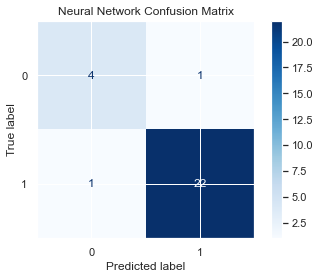

In [87]:
matrix = plot_confusion_matrix(nn_seq_3_model, X_test_3, y_test_3,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

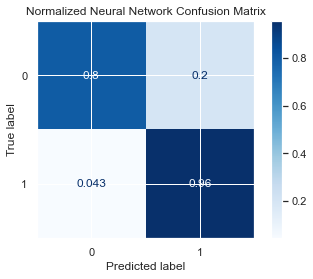

In [88]:
matrix = plot_confusion_matrix(nn_seq_3_model, X_test_3, y_test_3,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# NN4 - [wnt3 vs group3] decomposed from rest2

In [89]:
fourth_target = df["molecular"]

In [90]:
fourth_target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [91]:
fourth_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)

In [92]:
fourth_target = fourth_target.map(dict(wnt = 0, shh = -1, group3 = 1))
fourth_target = fourth_target[fourth_target != -1]
fourth_features = fourth_features.iloc[fourth_target.index]

In [93]:
fourth_target.value_counts()

1    154
0     26
Name: molecular, dtype: int64

In [94]:
fourth_target = fourth_target.reset_index(drop = True)
fourth_features = fourth_features.reset_index(drop = True)

In [95]:
reduced_features.head()

,wnt_rest,shh_rest,wnt_shh,wnt_group3,3way,group3_rest
0,sex,sex,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,sex,sex,sex
1,age,t1_log-sigma-1-mm-3D_firstorder_Median,t1_wavelet-LHL_glcm_Correlation,age,t1_log-sigma-3-mm-3D_firstorder_Median,age
2,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-5-mm-3D_glszm_GrayLevelVariance,t1_wavelet-LHL_glcm_Idn,t1_original_shape_Flatness,t1_original_glrlm_LowGrayLevelRunEmphasis,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLev...
3,t1_log-sigma-3-mm-3D_firstorder_90Percentile,t1_original_glszm_LargeAreaHighGrayLevelEmphasis,t2_wavelet-HHL_firstorder_InterquartileRange,t1_wavelet-HLH_firstorder_Skewness,t1_original_shape_Flatness,t1_log-sigma-3-mm-3D_firstorder_Median
4,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniform...,t1_original_shape_Flatness,t2_wavelet-LLL_firstorder_Kurtosis,t1_wavelet-LHL_glcm_Correlation,t1_wavelet-HLL_glcm_Correlation,t1_log-sigma-3-mm-3D_glcm_ClusterProminence


In [96]:
fourth_reduced_features_list = reduced_features.loc[reduced_features['wnt_group3'].isnull() == False, ['wnt_group3']].values.tolist()
fourth_reduced_features_list = [item for sublist in fourth_reduced_features_list for item in sublist]

In [97]:
fourth_features = fourth_features[fourth_reduced_features_list]

In [98]:
sex_binarized = fourth_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

fourth_features['sex'] = sex_binarized

In [99]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(fourth_features, fourth_target, 
                                                    test_size = 0.25, random_state = 42)

In [100]:
y_train_4.value_counts()

1    114
0     21
Name: molecular, dtype: int64

In [101]:
fourth_X = pd.concat([X_train_4, y_train_4], axis = 1)
fourth_X_0 = fourth_X[fourth_X['molecular'] == 0]
fourth_X_1 = fourth_X[fourth_X['molecular'] == 1]

In [102]:
fourth_upsampled_0 = resample(fourth_X_0, replace = True, n_samples = len(fourth_X_1), random_state = 42)
fourth_upsampled = pd.concat([fourth_upsampled_0, fourth_X_1])
fourth_upsampled = fourth_upsampled.sample(frac = 1, random_state = 42)

In [103]:
X_train_4 = fourth_upsampled.iloc[:, :-1]
y_train_4 = fourth_upsampled.iloc[:, -1]

In [104]:
y_train_4.value_counts()

1    114
0    114
Name: molecular, dtype: int64

In [105]:
fourth_names = X_train_4.columns
fourth_scaler = preprocessing.StandardScaler()

In [106]:
X_train_4 = fourth_scaler.fit_transform(X_train_4)
X_train_4 = pd.DataFrame(X_train_4, columns = fourth_names)

In [107]:
X_test_4 = fourth_scaler.transform(X_test_4)
X_test_4 = pd.DataFrame(X_test_4, columns = fourth_names)

In [108]:
nn_model_4_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_seq_4_grid = GridSearchCV(estimator=nn_model_4_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [109]:
nn_seq_4_grid.fit(X_train_4, y_train_4)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [110]:
print(nn_seq_4_grid.best_params_)

{'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}


In [111]:
nn_seq_4_model = MLPClassifier(hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_seq_4_model.fit(X_train_4, y_train_4)
y_pred_4 = nn_seq_4_model.predict(X_test_4)

In [112]:
accuracy_score(y_test_4, y_pred_4)

0.9777777777777777

In [113]:
print("Accuracy Score: " + str(accuracy_score(y_test_4, y_pred_4)))
print("Specificity Score: " + str(specificity_score(y_test_4.to_numpy(), y_pred_4)))
print("Precision: " + str(precision_score(y_test_4, y_pred_4)))
print("Recall: " + str(recall_score(y_test_4, y_pred_4)))
print("F1 Score: " + str(f1_score(y_test_4, y_pred_4)))

print("PPV Score: " + str(positive_pv_score(y_test_4.to_numpy(), y_pred_4)))
print("NPV Score: " + str(negative_pv_score(y_test_4.to_numpy(), y_pred_4)))

Accuracy Score: 0.9777777777777777
Specificity Score: 1.0
Precision: 1.0
Recall: 0.975
F1 Score: 0.9873417721518987
PPV Score: 1.0
NPV Score: 0.8333333333333334


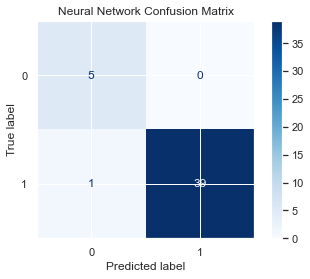

In [114]:
matrix = plot_confusion_matrix(nn_seq_4_model, X_test_4, y_test_4,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

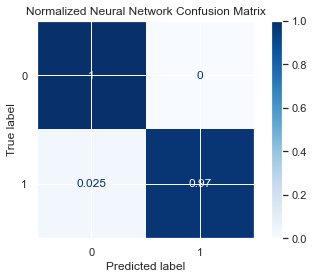

In [115]:
matrix = plot_confusion_matrix(nn_seq_4_model, X_test_4, y_test_4,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# Testing

In [116]:
test_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1) 
test_target = df["molecular"]

In [117]:
test_target = test_target.map(dict(wnt = 0, shh = 1, group3 = 2))

In [118]:
X_train, X_test, y_train, y_test = train_test_split(test_features, test_target, 
                                                    test_size = 0.25, random_state = 42)

In [119]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [120]:
sex_binarized = X_test['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_test['sex'] = sex_binarized

In [121]:
X_test_reduced = X_test[reduced_features_list]

In [122]:
names = X_test_reduced.columns
X_test_for_first = first_scaler.transform(X_test_reduced)
X_test_for_first = pd.DataFrame(X_test_for_first, columns = names)

In [123]:
y_preds_after_first = nn_seq_1_model.predict(X_test_for_first)

In [124]:
y_preds_after_first

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [125]:
np.array(y_test)

array([1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1,
       2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0])

In [126]:
wnt_1_indices = np.where(y_preds_after_first == 0)
other_indices_1 = np.where(y_preds_after_first != 0)

In [127]:
wnt_1_preds = y_preds_after_first[wnt_1_indices]
y_test_for_wnt_1 = np.array(y_test)[wnt_1_indices]

In [179]:
X_test_after_first_model = X_test.iloc[other_indices_1].reset_index(drop = True)
y_test_after_first_model = y_test.iloc[other_indices_1].reset_index(drop = True)

### shh1 vs rest2

In [190]:
X_test_reduced_2 = X_test_after_first_model[second_reduced_features_list]

In [192]:
names = X_test_reduced_2.columns
X_test_for_second = second_scaler.transform(X_test_reduced_2)
X_test_for_second = pd.DataFrame(X_test_for_second, columns = names)

In [193]:
y_preds_after_second = nn_seq_2_model.predict(X_test_for_second)

In [194]:
y_preds_after_second

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [195]:
np.array(y_test_after_first_model)

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0,
       1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0])

In [196]:
shh_1_indices = np.where(y_preds_after_second == 0)
other_indices_2 = np.where(y_preds_after_second != 0)

In [198]:
shh_1_preds = y_preds_after_second[shh_1_indices]
y_test_for_shh_1 = np.array(y_test_after_first_model)[shh_1_indices]

In [201]:
X_test_after_second_model_1 = X_test_after_first_model.iloc[shh_1_indices].reset_index(drop = True)
y_test_after_second_model_1 = y_test_after_first_model.iloc[shh_1_indices].reset_index(drop = True)

X_test_after_second_model_2 = X_test_after_first_model.iloc[other_indices_2].reset_index(drop = True)
y_test_after_second_model_2 = y_test_after_first_model.iloc[other_indices_2].reset_index(drop = True)

### wnt2 vs shh2

In [204]:
X_test_after_second_model_1 = X_test_after_second_model_1[third_reduced_features_list]

In [206]:
X_test_after_second_model_1 = third_scaler.transform(X_test_after_second_model_1)

In [210]:
y_test_after_second_model_1 = np.array(y_test_after_second_model_1)

In [208]:
y_preds_after_third = nn_seq_3_model.predict(X_test_after_second_model_1)

In [211]:
y_preds_overall = np.concatenate([y_preds_after_third, wnt_1_preds])
y_test_overall = np.concatenate([y_test_after_second_model_1, y_test_for_wnt_1])

### wnt3 vs group31

In [216]:
X_test_after_second_model_2 = X_test_after_second_model_2[fourth_reduced_features_list]

In [217]:
X_test_after_second_model_2 = fourth_scaler.transform(X_test_after_second_model_2)

In [218]:
y_test_after_second_model_2 = np.array(y_test_after_second_model_2)

In [219]:
y_preds_after_fourth = nn_seq_4_model.predict(X_test_after_second_model_2)

In [220]:
y_preds_after_fourth[y_preds_after_fourth == 1] = 2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [224]:
y_preds_overall = np.concatenate([y_preds_overall, y_preds_after_fourth])
y_test_overall = np.concatenate([y_test_overall, y_test_after_second_model_2])

In [228]:
accuracy_score(y_test_overall, y_preds_overall)

0.8787878787878788

In [230]:
sns.reset_orig()

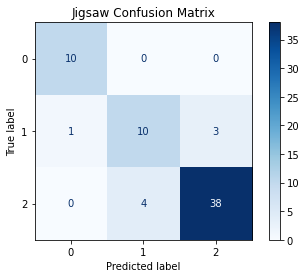

In [231]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues)
plt.title('Jigsaw Confusion Matrix')
plt.show(matrix)
plt.show()

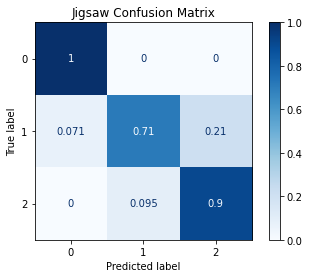

In [232]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues, normalize = 'true')
plt.title('Jigsaw Confusion Matrix')
plt.show(matrix)
plt.show()

In [233]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_overall, y_preds_overall)

Specificities
0 0.9821428571428571
1 0.9230769230769231
2 0.875
Macro Avg : 0.9267399267399267
Micro Avg : 0.9393939393939394 

PPV/Precision
0 0.9090909090909091
1 0.7142857142857143
2 0.926829268292683
Macro Avg : 0.8500686305564354
Micro Avg : 0.8787878787878788 

NPV
0 1.0
1 0.9230769230769231
2 0.84
Macro Avg : 0.9210256410256411
Micro Avg : 0.9393939393939394 

Recall
0 1.0
1 0.7142857142857143
2 0.9047619047619048
Macro Avg : 0.873015873015873
Micro Avg : 0.8787878787878788 

F1 Score
0 0.9523809523809523
1 0.7142857142857143
2 0.9156626506024096
Macro Avg : 0.8613894514053835
Micro Avg : 0.8787878787878788 

Accuracy:
0 0.9848484848484849
1 0.8787878787878788
2 0.8939393939393939
Macro Avg : 0.9191919191919192
Micro Avg : 0.9191919191919192 



In [234]:
y_test_bin = label_binarize(y_test_overall, classes = [0, 1, 2])
y_pred_bin = label_binarize(y_preds_overall, classes = [0, 1, 2])

In [235]:
n_classes = 3

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test_overall), len(y_test_overall))
    if len(np.unique(y_test_overall[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    for i in range(n_classes):
        one_acc.append(accuracy_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_spec.append(specificity_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_prec.append(precision_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_rec.append(recall_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_f_one.append(f1_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##

    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [236]:
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the Accuracy score for class 0: [0.9545 - 1.0]
95% Confidence interval for the Accuracy score for class 1: [0.7879 - 0.9545]
95% Confidence interval for the Accuracy score for class 2: [0.8030 - 0.9697]
95% Confidence interval for the Specificity score for class 0: [0.9444 - 1.0]
95% Confidence interval for the Specificity score for class 1: [0.8421 - 0.9821]
95% Confidence interval for the Specificity score for class 2: [0.7273 - 1.0]
95% Confidence interval for the Precision score for class 0: [0.7143 - 1.0]
95% Confidence interval for the Precision score for class 1: [0.4444 - 0.9333]
95% Confidence interval for the Precision score for class 2: [0.8261 - 1.0]
95% Confidence interval for the Recall score for class 0: [1.0000 - 1.0]
95% Confidence interval for the Recall score for class 1: [0.4545 - 0.9412]
95% Confidence interval for the Recall score for class 2: [0.8000 - 0.9783]
95% Confidence interval for the F1 score for class 0: [0.8333 - 1.0]
95% Con

# Classification Results

In [86]:
metadata_df = df['molecular']
target_for_table = df['molecular']

In [87]:
features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
target_for_table = target_for_table.map(dict(group3 = 0, shh = 1, wnt = 2))

In [88]:
#only used for metadata for which is train and which is test
X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table, 
                                                    test_size = 0.25, random_state = 42)

In [89]:
X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

<ipython-input-89-e808b9f961f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_for_table['Set'] = 'training'
<ipython-input-89-e808b9f961f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_table['Set'] = 'test'


In [90]:
X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

In [91]:
final_df = X_for_table[['molecular', 'Set']]
features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
target_for_table = X_for_table['molecular']
target_for_table = target_for_table.map(dict(group3 = 0, shh = 1, wnt = 2))

In [92]:
X_table_reduced = features_for_table[reduced_features_list]

In [93]:
sex_binarized = X_table_reduced['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_table_reduced['sex'] = sex_binarized

<ipython-input-93-ad9946e9319b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_table_reduced['sex'] = sex_binarized


In [94]:
names = X_table_reduced.columns
X_table_for_first = first_scaler.transform(X_table_reduced)
X_table_for_first = pd.DataFrame(X_table_for_first, columns = names)

In [95]:
y_probs_after_first_table = nn_seq_1_model.predict_proba(X_table_for_first)

In [96]:
y_probs_after_first_table

array([[2.46448174e-04, 9.99753552e-01],
       [3.56380555e-08, 9.99999964e-01],
       [2.47167236e-04, 9.99752833e-01],
       [9.99999999e-01, 7.32627794e-10],
       [8.01021006e-03, 9.91989790e-01],
       [3.33777703e-03, 9.96662223e-01],
       [8.62677376e-01, 1.37322624e-01],
       [2.67640196e-03, 9.97323598e-01],
       [7.98174830e-04, 9.99201825e-01],
       [9.52831087e-01, 4.71689127e-02],
       [9.98905281e-01, 1.09471864e-03],
       [3.83525881e-03, 9.96164741e-01],
       [9.99926604e-01, 7.33959250e-05],
       [9.99489210e-01, 5.10790104e-04],
       [9.99990697e-01, 9.30309520e-06],
       [9.98517365e-01, 1.48263505e-03],
       [1.81765257e-01, 8.18234743e-01],
       [9.99241229e-01, 7.58770714e-04],
       [9.99999392e-01, 6.08101139e-07],
       [1.97380978e-02, 9.80261902e-01],
       [9.99202758e-01, 7.97241651e-04],
       [9.99871112e-01, 1.28887684e-04],
       [3.93925868e-01, 6.06074132e-01],
       [9.99472325e-01, 5.27675097e-04],
       [9.707792

In [97]:
rf_1_table = pd.DataFrame(y_probs_after_first_table, columns = ['NN1 Group3 Prob','NN1 Non-Group3 Prob'])

In [98]:
final_df['NN1 Group3 Prob'] = rf_1_table['NN1 Group3 Prob']
final_df['NN1 Non-Group3 Prob'] = rf_1_table['NN1 Non-Group3 Prob']

<ipython-input-98-5e198a2d4aee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['NN1 Group3 Prob'] = rf_1_table['NN1 Group3 Prob']
<ipython-input-98-5e198a2d4aee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['NN1 Non-Group3 Prob'] = rf_1_table['NN1 Non-Group3 Prob']


In [99]:
y_preds_after_first_table = nn_seq_1_model.predict(X_table_for_first)
wnt_table_indices = np.where(y_preds_after_first_table == 0)
other_table_indices = np.where(y_preds_after_first_table != 0)

In [100]:
y_table_for_wnt = np.array(y_preds_after_first_table)[wnt_table_indices]
X_table_after_first_model = features_for_table.iloc[other_table_indices]
X_table_after_first_model = X_table_after_first_model[second_reduced_features_list]
X_table_after_first_model_arr = second_scaler.transform(X_table_after_first_model)

In [101]:
y_probs_after_second_table = nn_seq_2_model.predict_proba(X_table_after_first_model_arr)
y_preds_after_second_table = nn_seq_2_model.predict(X_table_after_first_model_arr)

In [102]:
nn_2_table = pd.DataFrame(y_probs_after_second_table, columns = ['NN2 SHH Prob','NN2 WNT Prob'])

In [103]:
X_table_after_first_model['NN2 SHH Prob'] = np.array(nn_2_table['NN2 SHH Prob'])
X_table_after_first_model['NN2 WNT Prob'] = np.array(nn_2_table['NN2 WNT Prob'])

In [104]:
X_table_after_first_model = X_table_after_first_model[['NN2 SHH Prob', 'NN2 WNT Prob']]

In [105]:
final_df = final_df.merge(X_table_after_first_model, how='left', left_index=True, right_index=True)

In [106]:
def f(row):
    if row['NN1 Non-Group3 Prob'] < row['NN1 Group3 Prob']:
        val = 'group3'
    else:
        if row['NN2 SHH Prob'] > row['NN2 WNT Prob']:
            val = 'shh'
        else:
            val = 'wnt'
    return val

In [107]:
final_df['molec_id'] = df['molec_id']

In [108]:
final_df['Pred Path'] = final_df.apply(f, axis = 1)

In [109]:
final_df

,molecular,Set,NN1 Group3 Prob,NN1 Non-Group3 Prob,NN2 SHH Prob,NN2 WNT Prob,molec_id,Pred Path
0,shh,training,2.464482e-04,9.997536e-01,0.999704,0.000296,BO_PF-MB_F_0007,shh
1,wnt,training,3.563806e-08,1.000000e+00,0.001124,0.998876,BO_PF-MB_F_0008,wnt
2,wnt,training,2.471672e-04,9.997528e-01,0.000036,0.999964,BO_PF-MB_F_0010,wnt
3,group3,training,1.000000e+00,7.326278e-10,NaN,NaN,BO_PF-MB_F_0015,group3
4,shh,training,8.010210e-03,9.919898e-01,0.998655,0.001345,BO_PF-MB_F_0017,shh
...,...,...,...,...,...,...,...,...
258,wnt,training,1.227053e-02,9.877295e-01,0.000003,0.999997,UT_PF-MB_M_0046,wnt
259,group3,test,9.978125e-01,2.187454e-03,NaN,NaN,UT_PF-MB_M_0047,group3
260,shh,training,3.626829e-03,9.963732e-01,0.994865,0.005135,UT_PF-MB_M_0048,shh
261,group3,training,9.982263e-01,1.773724e-03,NaN,NaN,UT_PF-MB_U_0034,group3


In [110]:
# Formatting
final_df.columns = ['True Molec', 'Set', 'NN1 Non-Group3 Prob', 'NN1 Group3 Prob',
                    'NN2 SHH Prob', 'NN2 WNT Prob', 'Molec Id', 'Pred Molec']
cols = final_df.columns.tolist()
cols = ['Molec Id', 'NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob', 
        'Pred Molec', 'True Molec', 'Set']
final_df = final_df[cols]
final_df = final_df.round(4)

In [111]:
pd.set_option('display.max_rows', None)
final_df

,Molec Id,NN1 Non-Group3 Prob,NN1 Group3 Prob,NN2 SHH Prob,NN2 WNT Prob,Pred Molec,True Molec,Set
0,BO_PF-MB_F_0007,0.0002,0.9998,0.9997,0.0003,shh,shh,training
1,BO_PF-MB_F_0008,0.0000,1.0000,0.0011,0.9989,wnt,wnt,training
2,BO_PF-MB_F_0010,0.0002,0.9998,0.0000,1.0000,wnt,wnt,training
3,BO_PF-MB_F_0015,1.0000,0.0000,NaN,NaN,group3,group3,training
4,BO_PF-MB_F_0017,0.0080,0.9920,0.9987,0.0013,shh,shh,training
5,BO_PF-MB_F_0018,0.0033,0.9967,0.4470,0.5530,wnt,wnt,training
6,BO_PF-MB_F_0019,0.8627,0.1373,NaN,NaN,group3,group3,test
7,BO_PF-MB_F_0020,0.0027,0.9973,1.0000,0.0000,shh,shh,training
8,BO_PF-MB_M_0004,0.0008,0.9992,0.9994,0.0006,shh,shh,training
9,BO_PF-MB_M_0009,0.9528,0.0472,NaN,NaN,group3,group3,test
